## ML

## Ассамблирование моделей

1.Предскажем цены на недвижимость, используя датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

2.Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

3.Построить случайный лес, вывести важность признаков

4.Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

5.Для валидации модели 2-го уровня использовать отдельный hold-out датасет

6.Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

### 1. Импорт библиотек / импорт и предобработка данных 

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, LassoCV
from sklearn.svm import SVR

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor

In [ ]:
data = pd.read_csv('train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 2. Feature Engineering

In [ ]:
data = data.drop(['Id'], axis = 1)                      # полностью дублирует поле Indexб информации не несет
data['MSSubClass'] = data['MSSubClass'].astype(object)  # классификатор типов недвижимости, категориальный признак

Выделяем группы категориальных признаков, носящих оценочный характер по заранее заданной шкале (качественная типовая оценка проф участника рынка от Poor до Excellent) и преобразуем оценки в числовые. Предполагаем что качественные оценки на 6 категорий в терминологии Poor - Exellent  и в терминологии 1,2,3,4,5,6 интуитивно и содержательно схожи

In [ ]:
quality_fich_1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC','KitchenQual',
                  'FireplaceQu','GarageQual', 'GarageCond', 'PoolQC']

for i in quality_fich_1: 
    data.loc[data[i]== 'Ex', i] = 10
    data.loc[data[i]== 'Gd', i] = 8
    data.loc[data[i]== 'TA', i] = 6
    data.loc[data[i]== 'Av', i] = 6
    data.loc[data[i]== 'Fa', i] = 4
    data.loc[data[i]== 'Po', i] = 2
    data.loc[data[i]== 'Mn', i] = 2
    data.loc[data[i]== 'NA', i] = 0
    data.loc[data[i]== 'No', i] = 0
    data.loc[data[i].isna(), i] = 0
    data[i]  = data[i].astype(int) 

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
quality_fich_2 = ['BsmtFinType1', 'BsmtFinType2']

for i in quality_fich_2: 
    data.loc[data[i]== 'GLQ', i] = 6
    data.loc[data[i]== 'ALQ', i] = 5
    data.loc[data[i]== 'BLQ', i] = 4
    data.loc[data[i]== 'Rec', i] = 3
    data.loc[data[i]== 'LwQ', i] = 2
    data.loc[data[i]== 'Unf', i] = 1
    data.loc[data[i]== 'NA', i] = 0
    data.loc[data[i].isna(), i] = 0
    data[i]  = data[i].astype(int) 

In [ ]:
quality_fich_so_so = ['BsmtExposure', 'GarageFinish']
for i in quality_fich_so_so: 
    data.loc[data[i]== 'Gd', i] = 3
    data.loc[data[i]== 'Av', i] = 2
    data.loc[data[i]== 'Mn', i] = 1
    data.loc[data[i]== 'No', i] = 0
    data.loc[data[i]== 'Fin', i] = 3
    data.loc[data[i]== 'RFn', i] = 2
    data.loc[data[i]== 'Unf', i] = 1
    data.loc[data[i]== 'NA', i]  = 0
    data.loc[data[i].isna(), i] = 0
    data[i]  = data[i].astype(int) 

Ряд признаков преобразуем в бинарные: улица или аллея мощенные или нет, аллея на уличе есть / нет и и т д

In [ ]:
data.loc[data.Alley == 'NA',  'Alley_fact'] = 0
data.loc[data.Alley.isna(),   'Alley_fact'] = 0
data.Alley_fact.fillna(1, inplace = True)
data.Alley_fact = data.Alley_fact.astype(int)

In [ ]:
binary_fich = ['Street', 'Alley', 'CentralAir', 'PavedDrive']

for i in binary_fich: 
    data.loc[data[i]== 'Y', i]    = 1
    data.loc[data[i]== 'Pave', i] = 1
    data.loc[data[i]== 'P', i]    = 0.5
    data.loc[data[i]== 'Grvl', i] = 0
    data.loc[data[i]== 'N',    i] = 0
    data.loc[data[i].isna(), i]   = 0
    data[i]  = data[i].astype(int) 

Признаки Condition1 и Condition2  (равно как и Exterior1st, Exterior2nd) описывают 2 характеристики одного и того же объекта. Предположим, что каждая из пары характеристик равнозначна,  тогда пара признаков должна раскладываться на dummies единожды

In [ ]:
Condition_dumm = data[['Condition1','Condition2']].stack().str.get_dummies().sum(level=0)
Condition_dumm[Condition_dumm > 1] = 1
Condition_dumm.head(2)

,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
0,0,0,1,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0


In [ ]:
Exterior_dumm = data[['Exterior1st','Exterior2nd']].stack().str.get_dummies().sum(level=0)
Exterior_dumm[Exterior_dumm > 1] = 1
Exterior_dumm.head(2)

,AsbShng,AsphShn,Brk Cmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,WdShing
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
data = data.drop(['Condition1','Condition2','Exterior1st','Exterior2nd'], axis = 1)

Исходя из моего понимания описания датасета признаки OverallQual и OverallCond представляют собой сводную оценку всех остальных признаков (качества и условий) недвижимости в составе датасета,  то есть каждый качественный признак недвижимости сидит в составе расчета сводного индекса OverallQual.  Если это так,  то нужно либо использовать только эти 2 параметра (и удалить все остальные), или поступим наоборот

In [ ]:
data = data.drop(['OverallQual', 'OverallCond' ], axis = 1)

Разбиваем признаки на числовые и категориальные

In [ ]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
num_feat = [f for f in data if f not in (cat_feat + ['SalePrice'])]

Для числовых признаков пустые значения заменяем на медианы и применяем StandardScaler

In [ ]:
num_median = data[num_feat].median().astype('int32')
data[num_feat] = data[num_feat].fillna(num_median)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[num_feat])

data[num_feat] = scaler.transform(data[num_feat])

... и сливаем это все в 1 большой х

In [ ]:
data_x = pd.concat([pd.get_dummies(data[cat_feat], columns=cat_feat),
                  Condition_dumm, 
                  Exterior_dumm,   
                  data[num_feat]              
                  ], axis=1)

data_x.head(1)

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,Alley_fact
0,0,0,0,0,0,1,0,0,0,0,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.066236,-0.087688,-1.599111,0.138777,-0.257821


### 3. Построение модели


In [ ]:
x  = data_x
Y  = data['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    Y, 
                                                    test_size = 0.15, 
                                                    random_state = 1000)

In [ ]:
RFR = RandomForestRegressor(n_estimators=500, max_features=5)

RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test)

y_pred_train, y_pred_test = RFR.predict(x_train), RFR.predict(x_test)

In [ ]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.9760309556634701, 0.8484471988790804)

In [ ]:
def cross_valid (model, metric):
    skf = KFold(n_splits=10, random_state=None, shuffle=False)
    train_metric, test_metric = [], []
    for train_index, test_index in skf.split(x, Y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        model.fit(x_train, y_train)
        y_pred_train, y_pred_test = model.predict(x_train), model.predict(x_test)
        train_metric.append(metric(y_train, y_pred_train))
        test_metric.append (metric(y_test, y_pred_test))
    print(model)
    print('train metric after cross val = ',  round(sum(train_metric)/len(train_metric),5))
    print('test  metric after cross val = ',  round(sum(test_metric)/len(test_metric),5))

In [ ]:
cross_valid (model = RFR, metric = r2_score)

RandomForestRegressor(max_features=5, n_estimators=500)
train metric after cross val =  0.97595
test  metric after cross val =  0.83099


Не работает в данном случае кросс валидация

In [ ]:
headers     = list(x.columns.values)
feature_imp = pd.Series(RFR.feature_importances_,index=headers).sort_values(ascending=False)
f_i_short   = feature_imp.head(15)

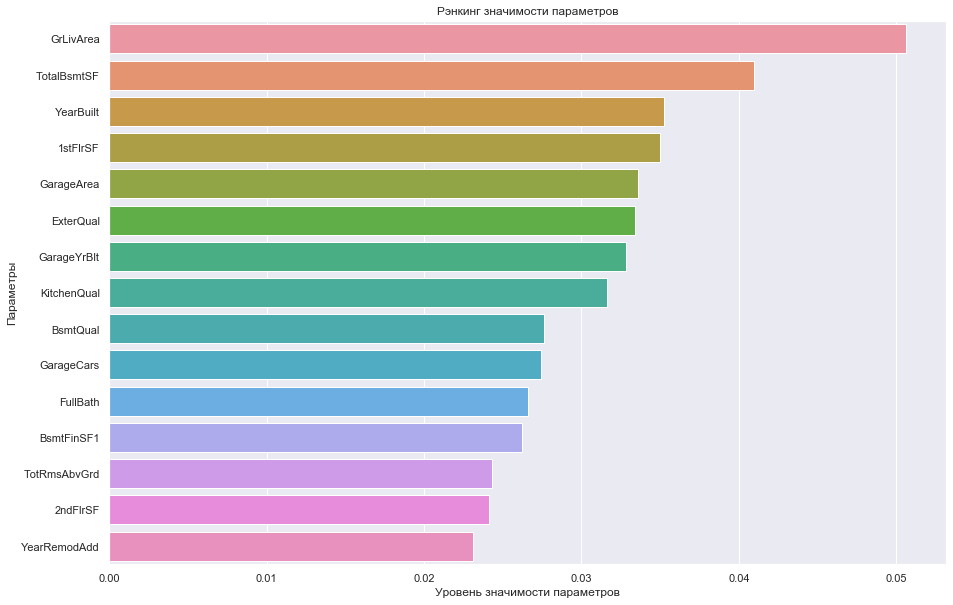

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=f_i_short, y=f_i_short.index)
plt.xlabel('Уровень значимости параметров')
plt.ylabel('Параметры')
plt.title('Рэнкинг значимости параметров')
plt.show()

Попробуем сократить количество признаков до Топ15  и посмотрим что это даст

In [ ]:
top_feat = list(f_i_short.index)
data_top_feat = data_x[top_feat]

In [ ]:
x  = data_top_feat
Y  = data['SalePrice'].astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    Y, 
                                                    test_size = 0.15, 
                                                    random_state = 1000)

In [ ]:
RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test)

y_pred_train, y_pred_test = RFR.predict(x_train), RFR.predict(x_test)

In [ ]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.9796006095191027, 0.881595015094991)

Сокращение количества признаков с 227 до 15 дало учеличение показателя r2 на тесте с 0.8519 до 0.8796, неплохо ... но нет предела совершенству - исключим мультиколлениарность в наиболее очевидных проявлениях

(15.0, 0.0)

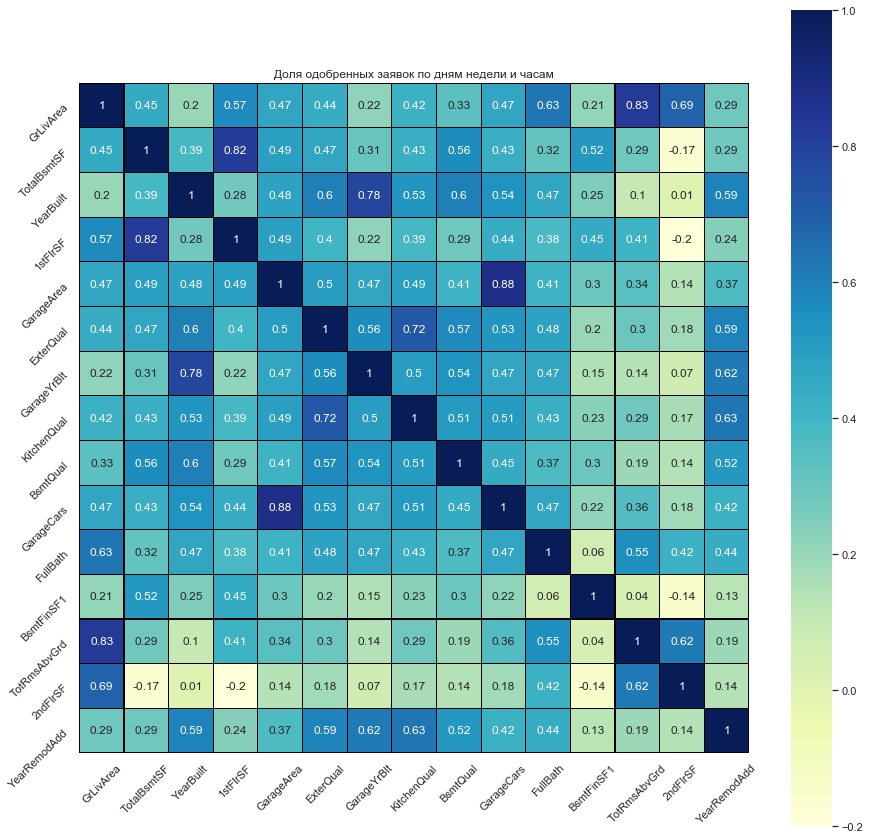

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(data_top_feat.corr().round(2),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Доля одобренных заявок по дням недели и часам')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [ ]:
data_top_top_feat = data_top_feat.drop(['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'], axis = 1)

In [ ]:
x  = data_top_top_feat
Y  = data['SalePrice'].astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    Y, 
                                                    test_size = 0.15, 
                                                    random_state = 1000)
RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test)
y_pred_train, y_pred_test = RFR.predict(x_train), RFR.predict(x_test)
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.9792701038446953, 0.8819484290634316)

Результат на тестовых данных все улучшается по мере сокращения количества признаков

### 4. Стекинг

In [ ]:
estimators = [
              ('lasso',  LassoCV(random_state=100)),              
              ('sgd',    SGDRegressor()),
              ('ridge',  RidgeCV()),
              ('rfr',    RandomForestRegressor()),
              ('abr',    AdaBoostRegressor())
            ]

In [ ]:
reg = StackingRegressor(
                        estimators=estimators,
                        final_estimator=GradientBoostingRegressor(random_state=100))

In [ ]:
reg.fit(x_train, y_train)

StackingRegressor(estimators=[('lasso', LassoCV(random_state=100)),
                              ('sgd', SGDRegressor()),
                              ('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('rfr', RandomForestRegressor()),
                              ('abr', AdaBoostRegressor())],
                  final_estimator=GradientBoostingRegressor(random_state=100))

In [ ]:
reg.final_estimator_.feature_importances_

array([0.14227697, 0.14556048, 0.47135641, 0.21086094, 0.0299452 ])

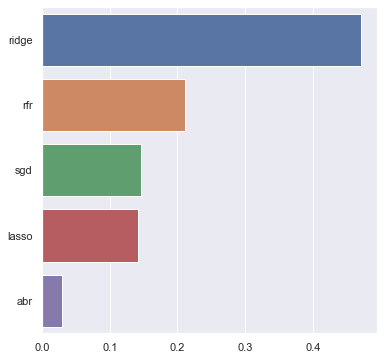

In [ ]:
headers = list(reg.named_estimators_.keys())
feature_imp = pd.Series(reg.final_estimator_.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

In [ ]:
r2_score(y_test, reg.predict(x_test))

0.8701849639592104

In [ ]:
p1 = []
for i in headers:
    p1.append(r2_score(y_test, reg.named_estimators_[i].predict(x_test)))
pd.Series(p1,index=headers).sort_values(ascending=False)

rfr      0.881205
sgd      0.812892
ridge    0.812367
lasso    0.811442
abr      0.718344
dtype: float64

In [ ]:
p1 = []
for i in headers:
    cross_valid (model = reg.named_estimators_[i], metric = r2_score)

LassoCV(random_state=100)
train metric after cross val =  0.77693
test  metric after cross val =  0.76948
SGDRegressor()
train metric after cross val =  0.77588
test  metric after cross val =  0.76803
RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
train metric after cross val =  0.77892
test  metric after cross val =  0.77201
RandomForestRegressor()
train metric after cross val =  0.97829
test  metric after cross val =  0.84329
AdaBoostRegressor()
train metric after cross val =  0.84283
test  metric after cross val =  0.75814


In [ ]:
cross_valid (model = reg, metric = r2_score)

StackingRegressor(estimators=[('lasso', LassoCV(random_state=100)),
                              ('sgd', SGDRegressor()),
                              ('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('rfr', RandomForestRegressor()),
                              ('abr', AdaBoostRegressor())],
                  final_estimator=GradientBoostingRegressor(random_state=100))
train metric after cross val =  0.92889
test  metric after cross val =  0.81308
